# Relationship between Features of Wine and Quality Rating

### Introduction

Red wine has specific attributes (acidity, sugar, alcohol, etc.) that determine its taste and perceived quality. The quality of red wine is often evaluated by professional sommeliers, a time-consuming and subjective assessment process. Attributes of red wine and its quality rating have been determined and collected into a data set that is donated to the UCI machine learning repository.

This project will take that data and attempt to answer the question:
*What attributes of wine affect wine quality and how?*

For relevant documentation and details of data set, reference [documentation](https://doi.org/10.1016/j.dss.2009.05.016).

The following are the potential predictor variables including their units:

|Variable|Units|
|--|--|
|Fixed acidity|g<sub>(tartaric acid)</sub>/dm<sup>3</sup>|
|Volatile acidity|g<sub>(acetic acid)</sub>/dm<sup>3</sup>|
|Citric acid|g/dm<sup>3</sup>|
|Residual sugar|g/dm<sup>3</sup>|
|Chlorides|g<sub>(sodium chloride)</sub>/dm<sup>3</sup>|
|Free sulfur dioxide|mg/dm<sup>3</sup>
|Total sulfur dioxide|mg/dm<sup>3</sup>|
|Density|g/cm<sup>3</sup>
|pH|0-14 pH scale|
|Sulphates|g<sub>(potassium sulphate)</sub>/dm<sup>3</sup>|
|Alcohol|vol. %|
|Quality|0-10 scale|

## Methods

Methods will include the [*Preliminary exploratory data analysis*](#pre_data_analysis) and the [*Data analysis*](#data_analysis) section

# \<richard and jason edit here\>

We will find the distribution of red wine quality first, and get the range of quality of the red wine. Then we will plot distribution of all predictors.
In this particular dataset, we have a total of 12 potential predictor variables, first, we will first select from these 12 potential predictor variables among the required predictors that have an impact on quality, and we will determine whether they have an impact on quality by their correlation with the quality by make plot to get all correlation coefficients of all predictors. We will find the predictors with strong correlation. However, the correlation may be small for all predictors which means all the predictors are weakly correlated with quality. So we can just choose the stonger predictors within all predictors.
**Although we are using correlation to pick which predictors, we still need to be aware that correlation does not imply causation(such as we’re missing a hidden and important factor).NO NEED?**


After selecting the predictors, we will start data analysis, and we decided to use the knn-classification model.  We will perform cross-validation with knn-classification based on the predictors we selected to predict the quality of the red wine.
Since we are trying to predict the quality of red wine which is a qualitative(categorical) ordinal variable(0,1,2,3,...,9,10), we will not be using knn-regression/linear regression model in this case. Although they are numbers, we cannot consider them as quatitive variables.



### Preliminary exploratory data analysis
<a id='pre_data_analysis'></a>
##### The preliminary exploratory data analysis will include:
- Reading dataset from web link
- Cleaning and wrangling data into a tidy format
- Splitting into training data and test data
- Summary statistics of training subset
- Visualization of training data predictors and determining appropriate predictors

In [1]:
# load necessary libraries
library(tidyverse)
library(tidymodels)
library(GGally)
library(RColorBrewer)

# initialize custom color palette
COLOR_PALETTE <- c("#F8766D", "#CD9600", "#00BE67", "#00A9FF", "#8A7AFF", "#FF33FC")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

#### Reading from web link
Read from link with appropriate delimiter.

In [2]:
# read data frame from UCI machine learning database
red_wine_link <- "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
# use ';' delimiter, read_csv2 will not work as '.' is used as decimal points
red_wine_data <- read_delim(red_wine_link, ';')

Rows: 1599 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
dbl (12): fixed acidity, volatile acidity, citric acid, residual sugar, chlo...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


#### Cleaning and Wrangling
After the data is read, the variable names are renamed to appropriate names.

Additionally, the quality variable is converted to a factor type, as it is a discrete variable.

In [3]:
# rename column names for easier reference
colnames(red_wine_data) <- c("fixed_acidity", "volatile_acidity", "citric_acid", 
                             "residual_sugar", "chlorides", "free_so2", "total_so2",
                             "density", "ph", "sulphates", "alcohol", "quality")

# convert quality to factor type
red_wine_data <- mutate(red_wine_data, quality = as_factor(quality))

# preview wine data and see dimensions of df
head(red_wine_data)
paste("Dimensions of data frame:", dim(red_wine_data))

fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_so2,total_so2,density,ph,sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5
7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5


[1] "Dimensions of data frame: 1599" "Dimensions of data frame: 12"

#### Splitting
Splitting the data involves some form of randomness, thus a seed is set for consistency.

The data is split with `SPLIT_PROPORTION` and strata `quality`.

In [4]:
# set seed for consistency
set.seed(8888)

# splitting data set into training and testing subsets
SPLIT_PROPORTION = 0.7
red_split_data <- initial_split(red_wine_data, prop = SPLIT_PROPORTION, strata = quality)

# assigning variables for respective training and testing data
red_training_data <- training(red_split_data)
red_testing_data <- testing(red_split_data)

# count the number of observations in each subset
paste("Number of observations in training data subset: ", pull(count(red_training_data)))
paste("Number of observations in testing data subset: ", pull(count(red_testing_data)))

[1] "Number of observations in training data subset:  1118"

[1] "Number of observations in testing data subset:  481"

#### Summary statistics of training data subset
Finding the number of `null` and `N/A` values, min, mean, max, and standard deviation.

<sub>Note: rules of tidy data do not apply to visual representation of statistics.</sub>

In [5]:
# check for null/na data
paste("Number of null values: ", sum(map_df(red_training_data, is.null)))
paste("Number of N/A values: ", sum(map_df(red_training_data, is.na)))

# code to produce summary statistics of the training data, not used as it is difficult to read
# summary(red_training_data)

# creating an abstract function for the sake of reducing repetitive code, acts as a "code template"
red_map <- function(fn) {
    red_training_data |>
    # remove quality, as it was decided to be the class variable and is now categorical
    select(-quality) |>
    # apply function from parameter into map function
    map_df(fn) |>
    # pivot for better view
    pivot_longer(cols = fixed_acidity:alcohol, values_to = as.character(substitute(fn)), names_to = "variable")
}

# example of what the function does when red_map(mean) is called
# red_training_mean <- red_training_data |>
#     select(-quality) |>
#     map_df(mean) |>
#     pivot_longer(cols = fixed_acidity:alcohol, values_to = "mean", names_to = "variable")

# bind all statistics together, but remove the variable column from all but first
bind_cols(red_map(min), select(red_map(mean), mean), select(red_map(max), max), select(red_map(sd), sd))

[1] "Number of null values:  0"

[1] "Number of N/A values:  0"

variable,min,mean,max,sd
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
fixed_acidity,4.60000,8.3238819,15.90000,1.762946065
volatile_acidity,0.12000,0.5257200,1.58000,0.179151475
citric_acid,0.00000,0.2719320,1.00000,0.195119564
residual_sugar,0.90000,2.5188283,15.50000,1.401099825
chlorides,0.01200,0.0877585,0.61100,0.049444296
free_so2,1.00000,16.0474061,68.00000,10.608373556
total_so2,6.00000,46.3524150,289.00000,33.178320311
density,0.99007,0.9967221,1.00369,0.001908595
ph,2.74000,3.3120125,4.01000,0.155939328


As seen above, there does not appear to be any invalid values of any variable in all the observations, so further wrangling to data in this stage is not necessary.
For some more familiar predictor variables, the values seem reasonable; it is commonly known for red wine to be acidic and have an alcohol content around 10%.

#### Visualization of training data subset and determining appropriate predictors

The last part involves plots that are relevant to the objective.
The first plot is a distribution of the `quality` class variable.

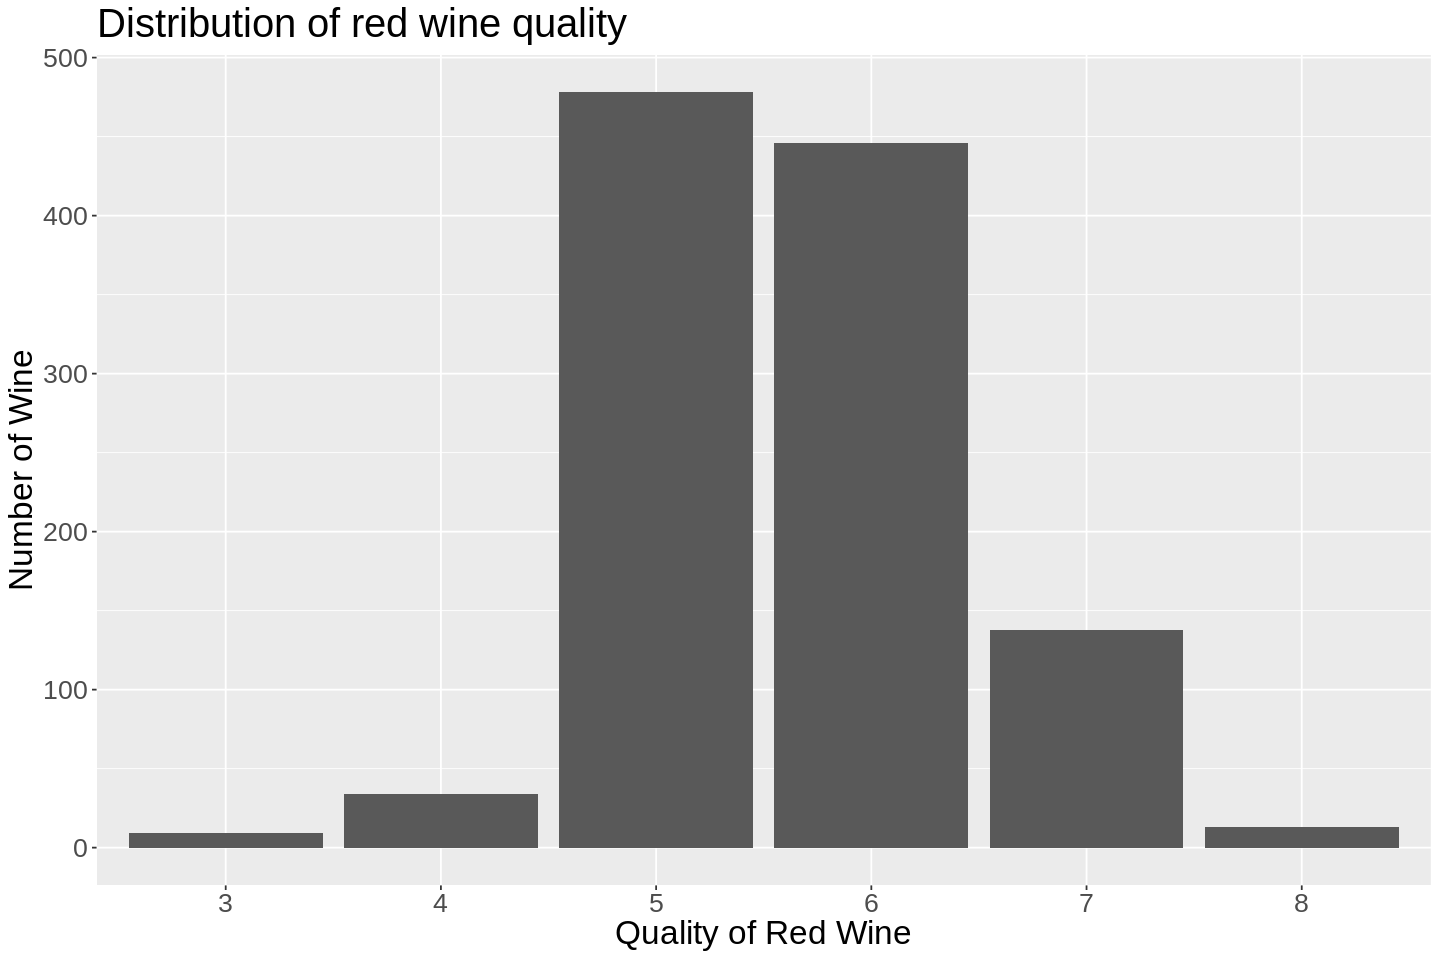

In [6]:
options(repr.plot.width = 12, repr.plot.height = 8)

#plotting the distribution of red wine quality
red_quality_bar <- ggplot(red_training_data, aes(x = quality)) +
    geom_bar() +
    labs(x = "Quality of Red Wine", y = "Number of Wine") + 
    ggtitle("Distribution of red wine quality") +
    theme(text = element_text(size = 20)

red_quality_bar

From the plot above, it can be seen that the `quality` variable is somewhat normally distributed with the center ~5. However, it is notable that the actual range of the testing data is from 3 to 8, despite the documentation noting it is on the scale from  0 to 10. This means that the possible results produced by models trained with this training data will have the `quality` variable range from 3 to 8.

Second plot is comparing the distribution of the potential predictor variables. The data is normalized with `scale()` and plotted as histograms with `facet_wrap()` for appropriate visual comparison. Outliers are removed to improve the visualization.

Warning message:
“Removed 129 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 22 rows containing missing values (geom_bar).”


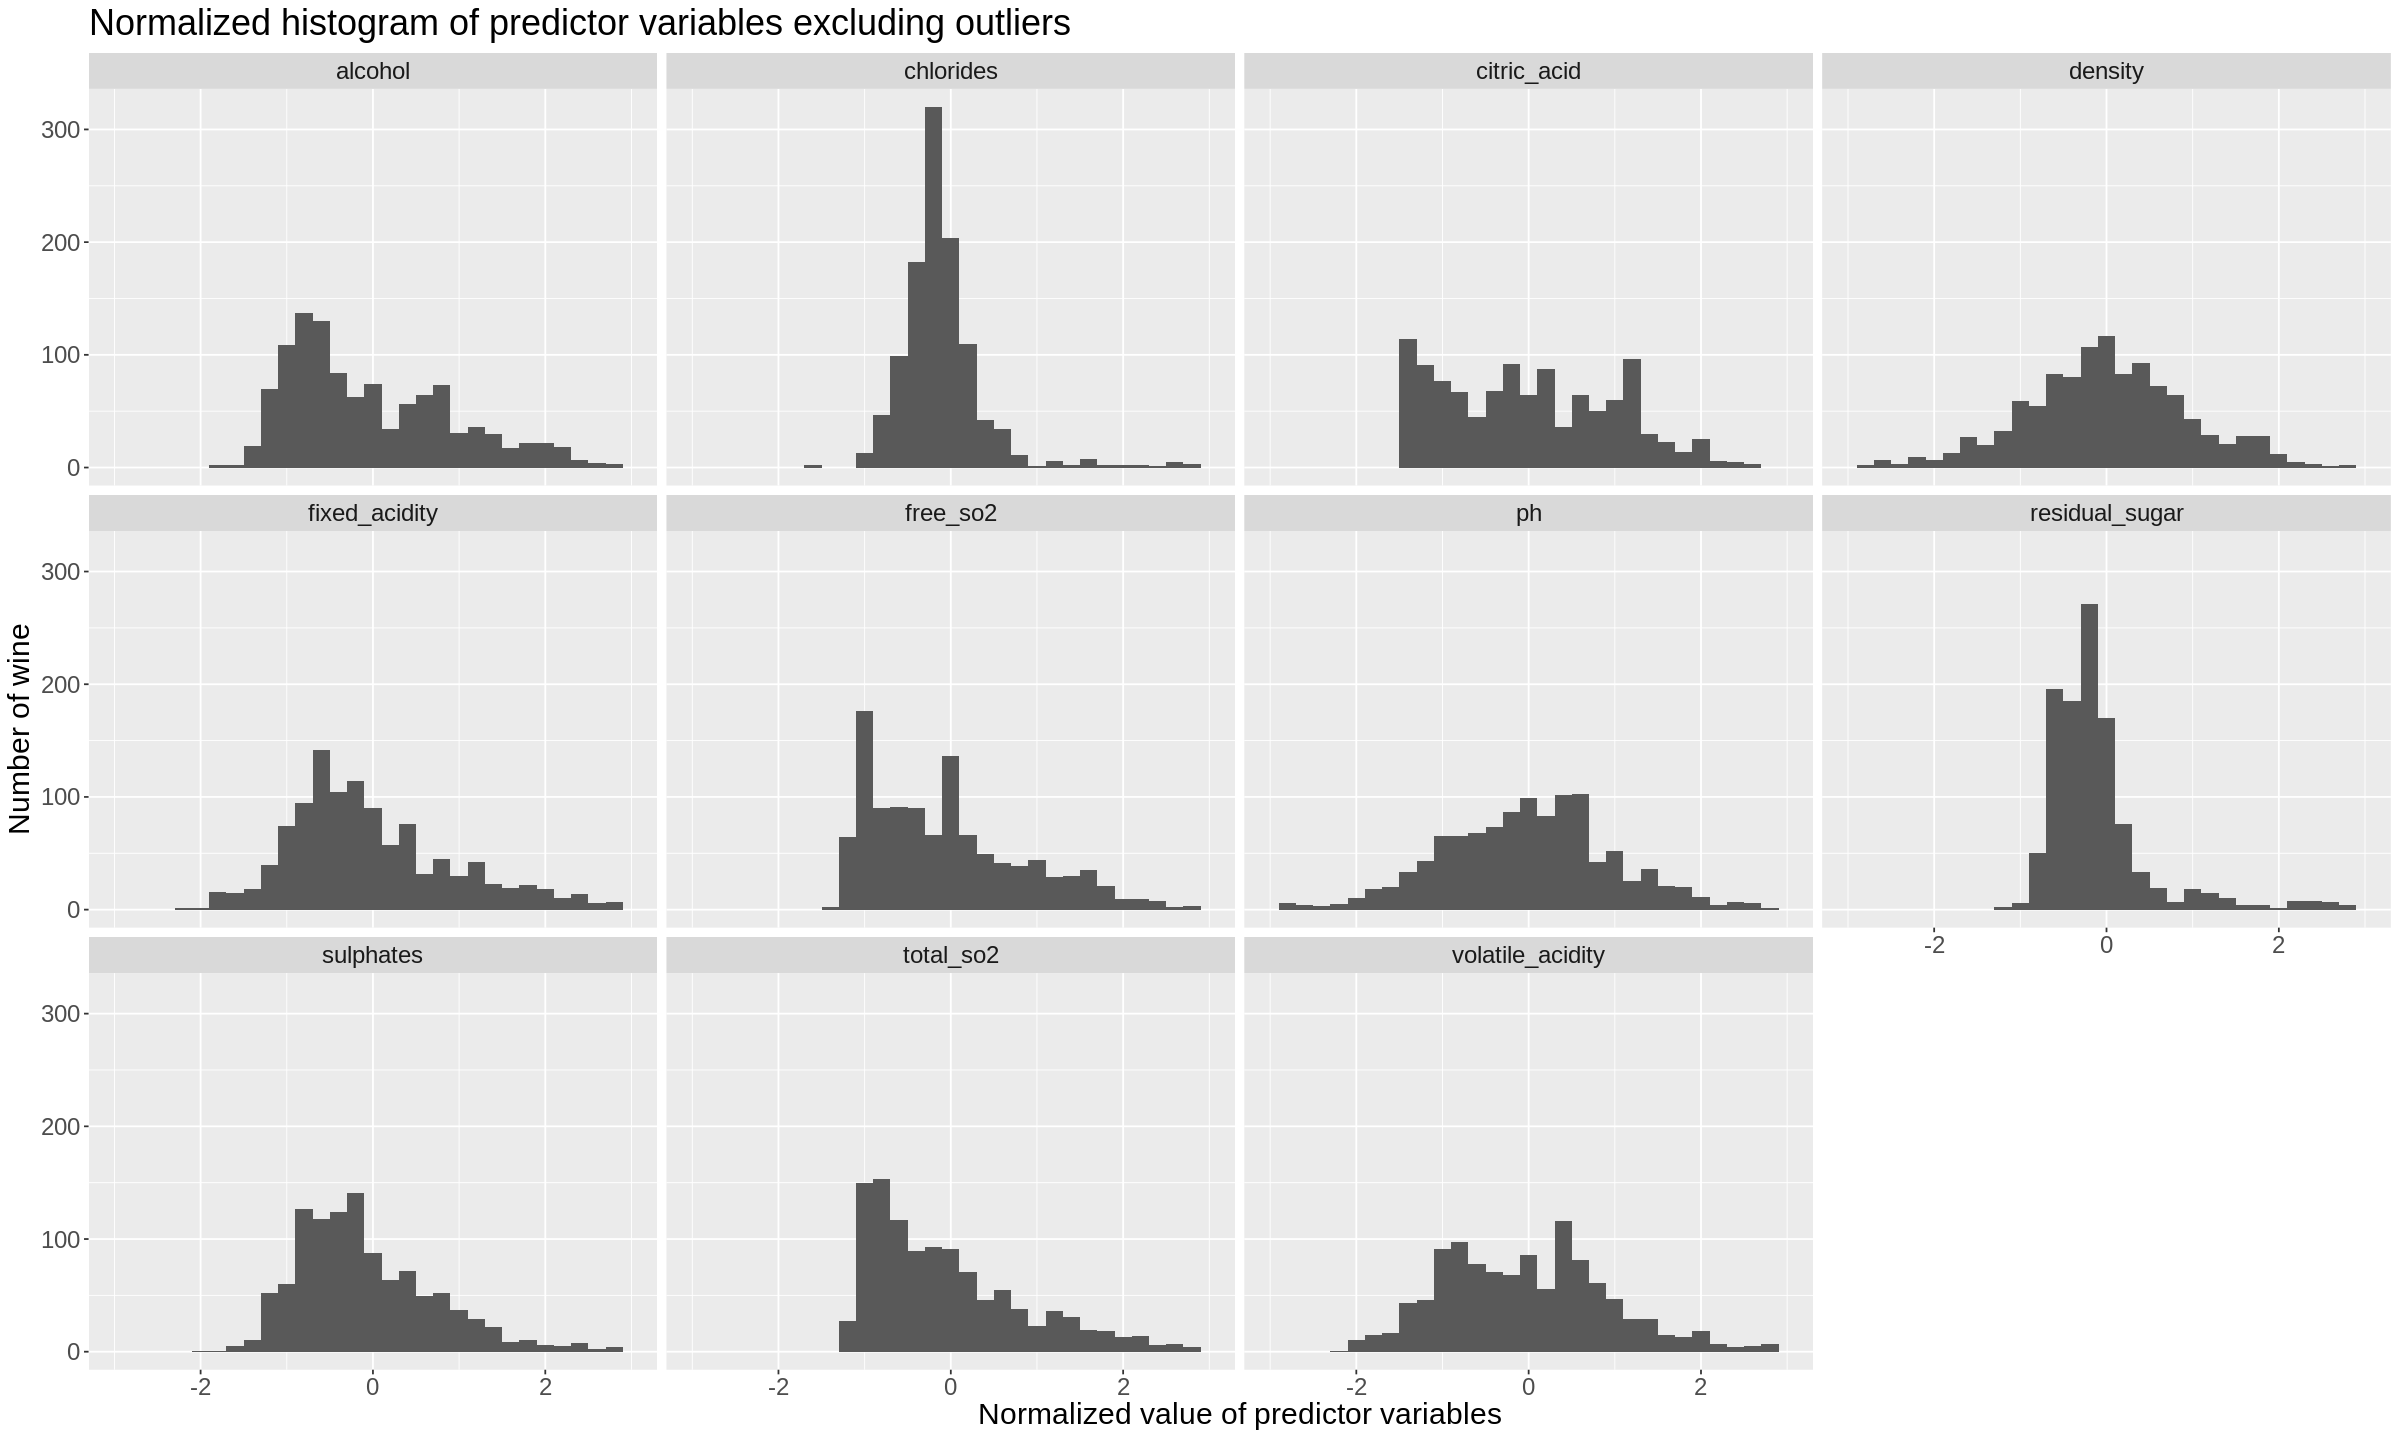

In [7]:
options(repr.plot.width = 20, repr.plot.height = 12)

# normalize the data with respect to each predictor variable
red_training_normalized <- red_training_data |>
    select(-quality) |>
    scale() |>
    as.data.frame()

# pivot data frame so that it is possible to plot histograms with
red_training_normalized_longer <- pivot_longer(red_training_normalized, cols = fixed_acidity:alcohol, names_to = "variable", values_to = "value")

# define binwidth constant
PREDICTOR_BINWIDTH <- 0.2

# plot histograms using facet_wrap. Also limit the horizontal axis to being within 3 standard deviations; beyond 3 SD are considered outliers and result in ideal visualization
red_predictor_histogram <- ggplot(red_training_normalized_longer, aes(x = value)) + 
    geom_histogram(binwidth = PREDICTOR_BINWIDTH) +
    facet_wrap(vars(variable)) +
    ggtitle("Normalized histogram of predictor variables excluding outliers") +
    labs(x = "Normalized value of predictor variables", y = "Number of wine") + 
    theme(text = element_text(size = 18)) +
    xlim(-3,3)

red_predictor_histogram

From the second plot, it can be seen that some of the predictor variable distributions tend to be positively skewed and some distributions have smaller ranges than others.

The third plot will involve `ggpairs()` from the `GGally` extension of `ggplot2`, which creates a scatter plot matrix with correlation coefficients that allows visualizations of relationships between predictor variables.

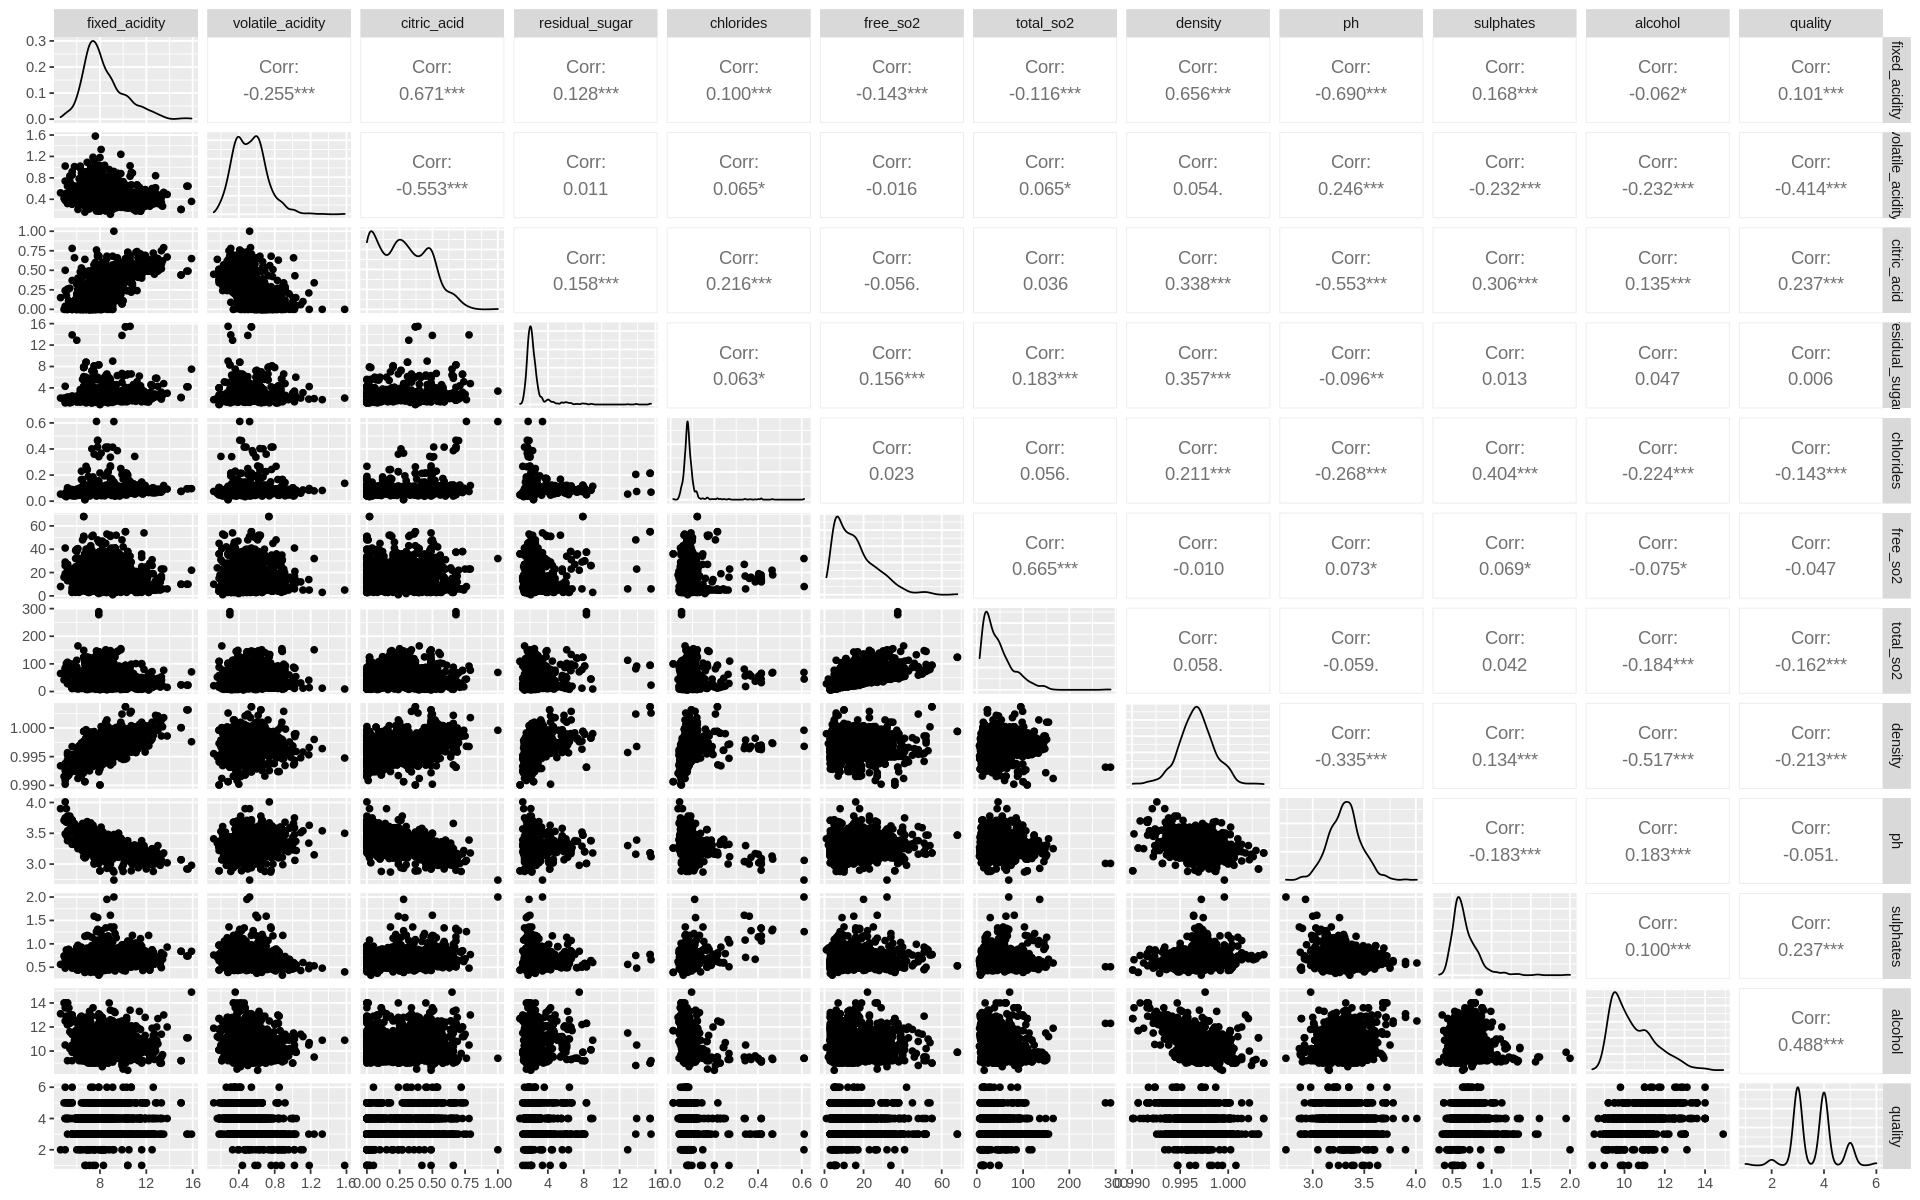

In [8]:
options(repr.plot.width = 16, repr.plot.height = 10)
#  quality is converted back to double type for calculations with correlation coefficient, as quality may also be treated as numeric
red_training_data_quality_as_double <- mutate(red_training_data, quality = as.double(quality))

ggpairs(red_training_data_quality_as_double)

From the `ggpairs()` visualization above, a notable observation to be made is that the correlation coefficients are all fairly low relative to the conventional "strong correlation" range of 0.8 - 1.0. As all the predictors would otherwise be considered weakly correlated with `quality`, the correlation coefficients' magnitudes between `quality` and predictor variables will be compared relatively in the training data set to determine which predictors are more strongly correlated with `quality` and thus more appropriate.

In [9]:
# calculate the correlation coefficients seen in the quality column of the ggpairs() visualization
cor_coef <- red_training_data_quality_as_double |>
    # use cor() to calculate coefficient of data frame, produces matrix
    cor() |>
    # convert to tibble (as_data_frame() is deprecated)
    as_tibble() |>
    # select coefficients with quality
    select(quality) |>
    # add correlating predictor names
    bind_cols(predictor_name = colnames(red_training_data)) |>
    # remove last row, as it's quality - quality correlation (it's equal to 1.0)
    head(-1)
cor_coef

cor_summ <- cor_coef |>
    # select column with correlation coefficients
    select(quality) |>
    # get magnitude of coefficients
    abs() |>
    # find median, sd, and the value at one sd higher than median
    # median is used as its less prone to outlier effects
    summarize(median = median(quality), sd = sd(quality)) |>
    mutate(one_sd = median + sd)
cor_summ

quality,predictor_name
<dbl>,<chr>
0.101432357,fixed_acidity
-0.413846117,volatile_acidity
0.236994316,citric_acid
0.005985591,residual_sugar
-0.143013768,chlorides
-0.047283553,free_so2
-0.162116419,total_so2
-0.213139483,density
-0.051134514,ph


median,sd,one_sd
<dbl>,<dbl>,<dbl>
0.1621164,0.1510338,0.3131502


From above, it can be seen that in terms of magnitude, six predictor variables are equal or higher than the median: `volatile_acidity`, `citric_acid`, `total_so2`, `density`, `sulphates`, and `alcohol`. Being higher than the median may be considered relatively stronger in correlation and the variable can be taken into consideration in further data analysis. 

However, two predictor variables can be observed to have correlation coefficient magnitudes larger than the value of one standard deviation higher than median (about 84th percentile): `volatile_acidity` and `alcohol`. Therefore, `quality` can be considered to have strong correlations with these two predictors. These two predictors are more appropriate and will be used in further data analyses.

### Data analysis
<a id='data_analysis'></a>
##### Data analysis will include:
- Initial visualization of the selected appropriate predictors with the class variable
- Training classification model using K-NN algorithm
- Training regression model using K-NN algorithm



#### Visualization of appropriate predictors and class variable

Below is a scatter plot, with the selected two predictors, volatile acidity and alcohol (had the strongest correlation with quality), on the axis and the class variable as the color.

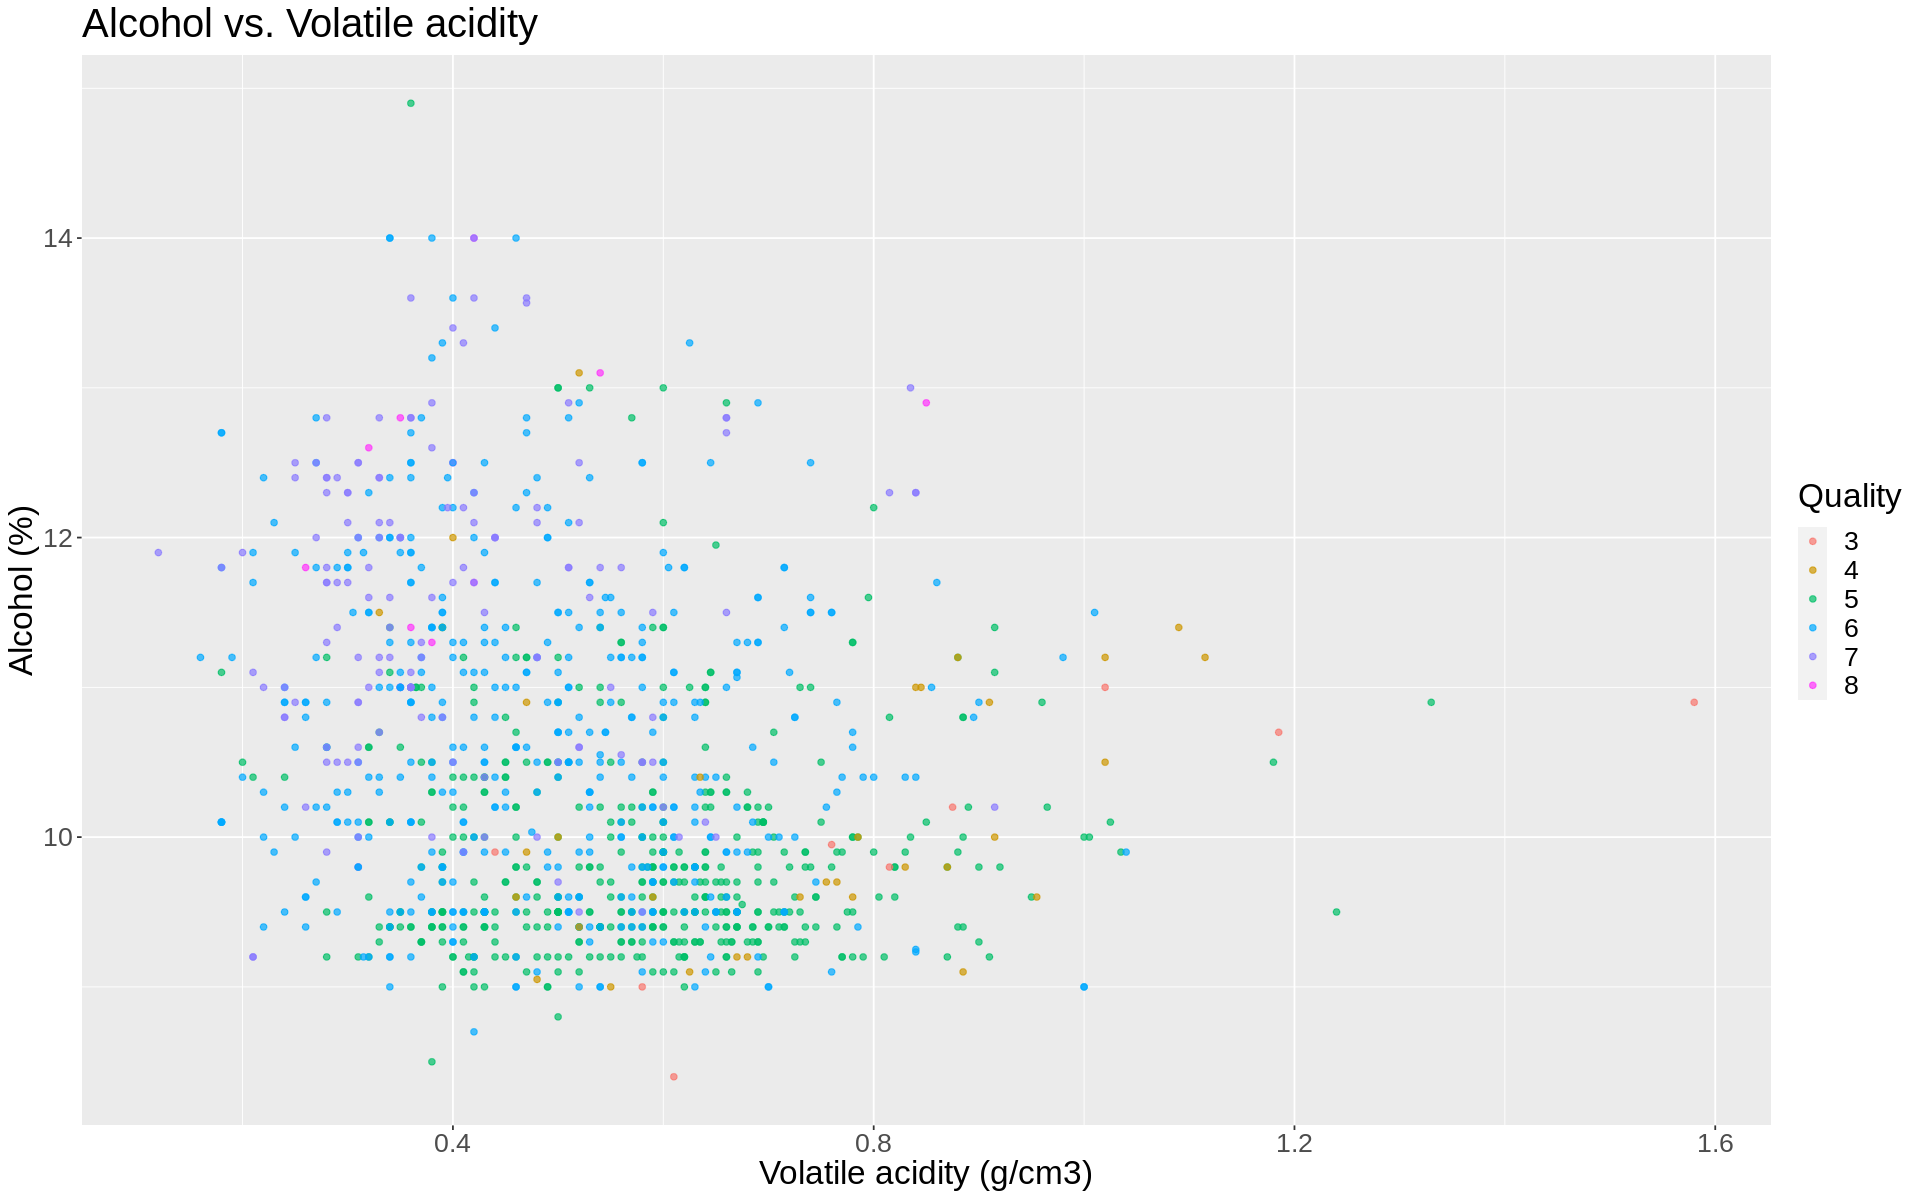

In [10]:
options(repr.plot.width = 16, repr.plot.height = 10)

red_scatter <- ggplot(red_training_data, aes(x = volatile_acidity, y = alcohol, color = quality)) + 
    geom_point(alpha = 0.7) +
    ggtitle("Alcohol vs. Volatile acidity") +
    labs(x = "Volatile acidity (g/cm3)", y = "Alcohol (%)", color = "Quality") + 
    theme(text = element_text(size = 20)) +
    # use customized palette
    scale_color_manual(values = COLOR_PALETTE)

red_scatter

# \<come back to this blah blah visualization is interesting\>




#### Training classification model with K-NN
something something find best k

! Fold2: internal:
  No observations were detected in `truth` for level(s): '8'
  Computation will proceed by ignoring those levels.



neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
40,accuracy,multiclass,0.5706609,5,0.007153930,Preprocessor1_Model01
40,roc_auc,hand_till,0.7340921,5,0.010075641,Preprocessor1_Model01
41,accuracy,multiclass,0.5697760,5,0.009367105,Preprocessor1_Model02
41,roc_auc,hand_till,0.7327701,5,0.009505648,Preprocessor1_Model02
42,accuracy,multiclass,0.5688671,5,0.010637184,Preprocessor1_Model03
42,roc_auc,hand_till,0.7322055,5,0.009423232,Preprocessor1_Model03


[1] "Highest accuracy when k = 70"

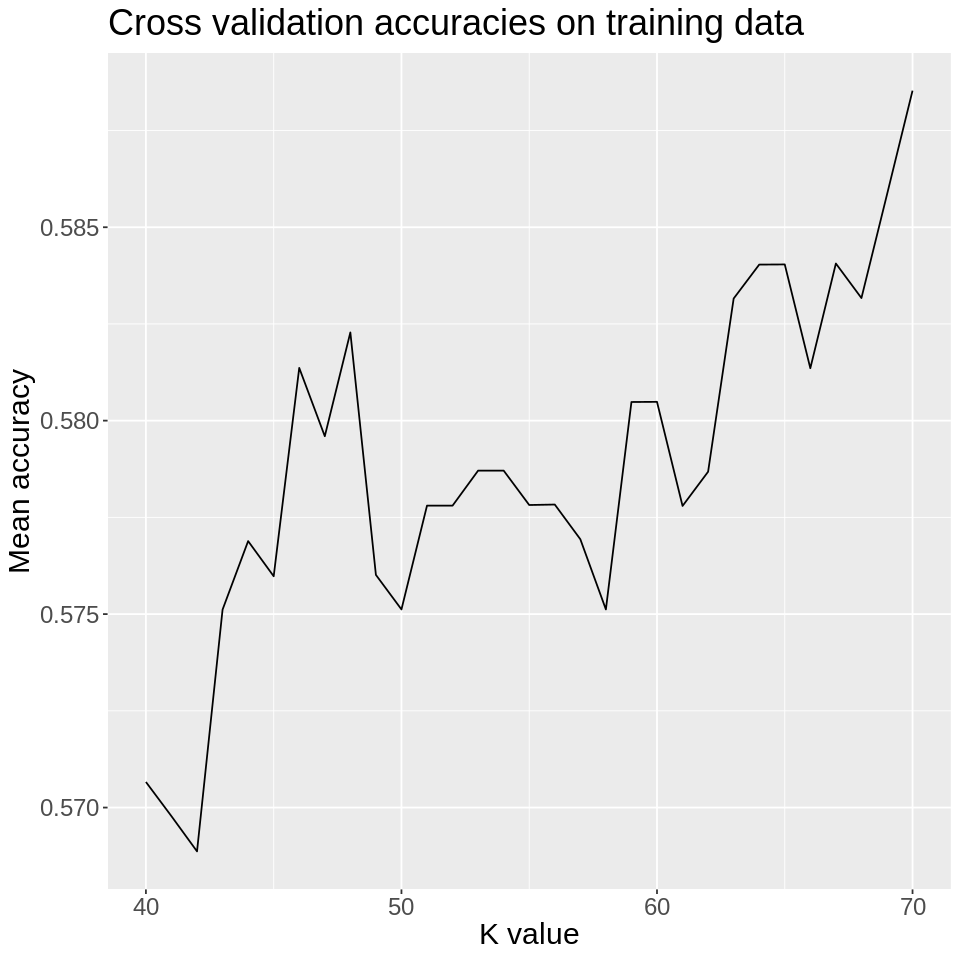

In [11]:
# create recipe
recipe <- recipe(quality ~ volatile_acidity + alcohol , data = red_training_data) |>
   step_scale(all_predictors()) |>
   step_center(all_predictors())

# model spec with tuning k
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# create cross validation with 5 folds
vfold <- vfold_cv(red_training_data, v = 5, strata = quality)

LOWER_K <- 40
UPPER_K <- 70
BY <- 1

# for values of k to test
# initially start with from = LOWER_K, to = UPPER_K, by = BY
grid_val <- tibble(neighbors = seq(from = LOWER_K, to = UPPER_K, by = BY))

# tune k
knn_results <- workflow() |>
      add_recipe(recipe) |>
      add_model(knn_tune) |>
      tune_grid(resamples = vfold, grid = grid_val) |>
      collect_metrics()
head(knn_results)

# pull k with greatest accuracy
k <- knn_results |> 
      filter(.metric == "accuracy") |>
      filter(mean == max(mean)) |>
      pull(neighbors)
paste("Highest accuracy when k =", k)

options(repr.plot.width = 8, repr.plot.height = 8)

# plot accuracies 
ggplot(filter(knn_results, .metric == "accuracy"), aes(x = neighbors, y = mean)) + 
    geom_line() +
    ggtitle("Cross validation accuracies on training data") +
    labs(x = "K value", y = "Mean accuracy") + 
    theme(text = element_text(size = 18))

In [12]:
# override value of k for testing/skip processing
#k <- 20

# create model spec with tuned k
knn_spec_tuned <- nearest_neighbor(weight_func = "rectangular", neighbors = k) |>
    set_engine("kknn") |>
    set_mode("classification")

# create fit with tuned model spec
fit <- workflow() |>
    add_recipe(recipe) |>
    add_model(knn_spec_tuned) |>
    fit(data = red_training_data)

# test classification model with testing data
test_predictions <- predict(fit, red_testing_data) |>
    bind_cols(red_testing_data)

# extract accuracy of predictions on testing data
prediction_accuracy <- test_predictions |>
    metrics(truth = quality, estimate = .pred_class)
prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.5384615
kap,multiclass,0.2308158


In [13]:
# create grid of volatile_acidity/alcohol values and arrange to data frame
# this is to be used as background color points for visualizing the classification model from training data
va_grid <- seq(min(red_training_data$volatile_acidity),
              max(red_training_data$volatile_acidity),
              length.out = 100)
al_grid <- seq(min(red_training_data$alcohol),
              max(red_training_data$alcohol),
              length.out = 100)
df_grid <- as_tibble(expand.grid(volatile_acidity = va_grid, alcohol = al_grid))

pred_table <- predict(fit, df_grid) |>
    bind_cols(df_grid) |>
    rename(quality = .pred_class)

# classification model with training data
train_predictions <- predict(fit, red_training_data) |>
    bind_cols(red_training_data)

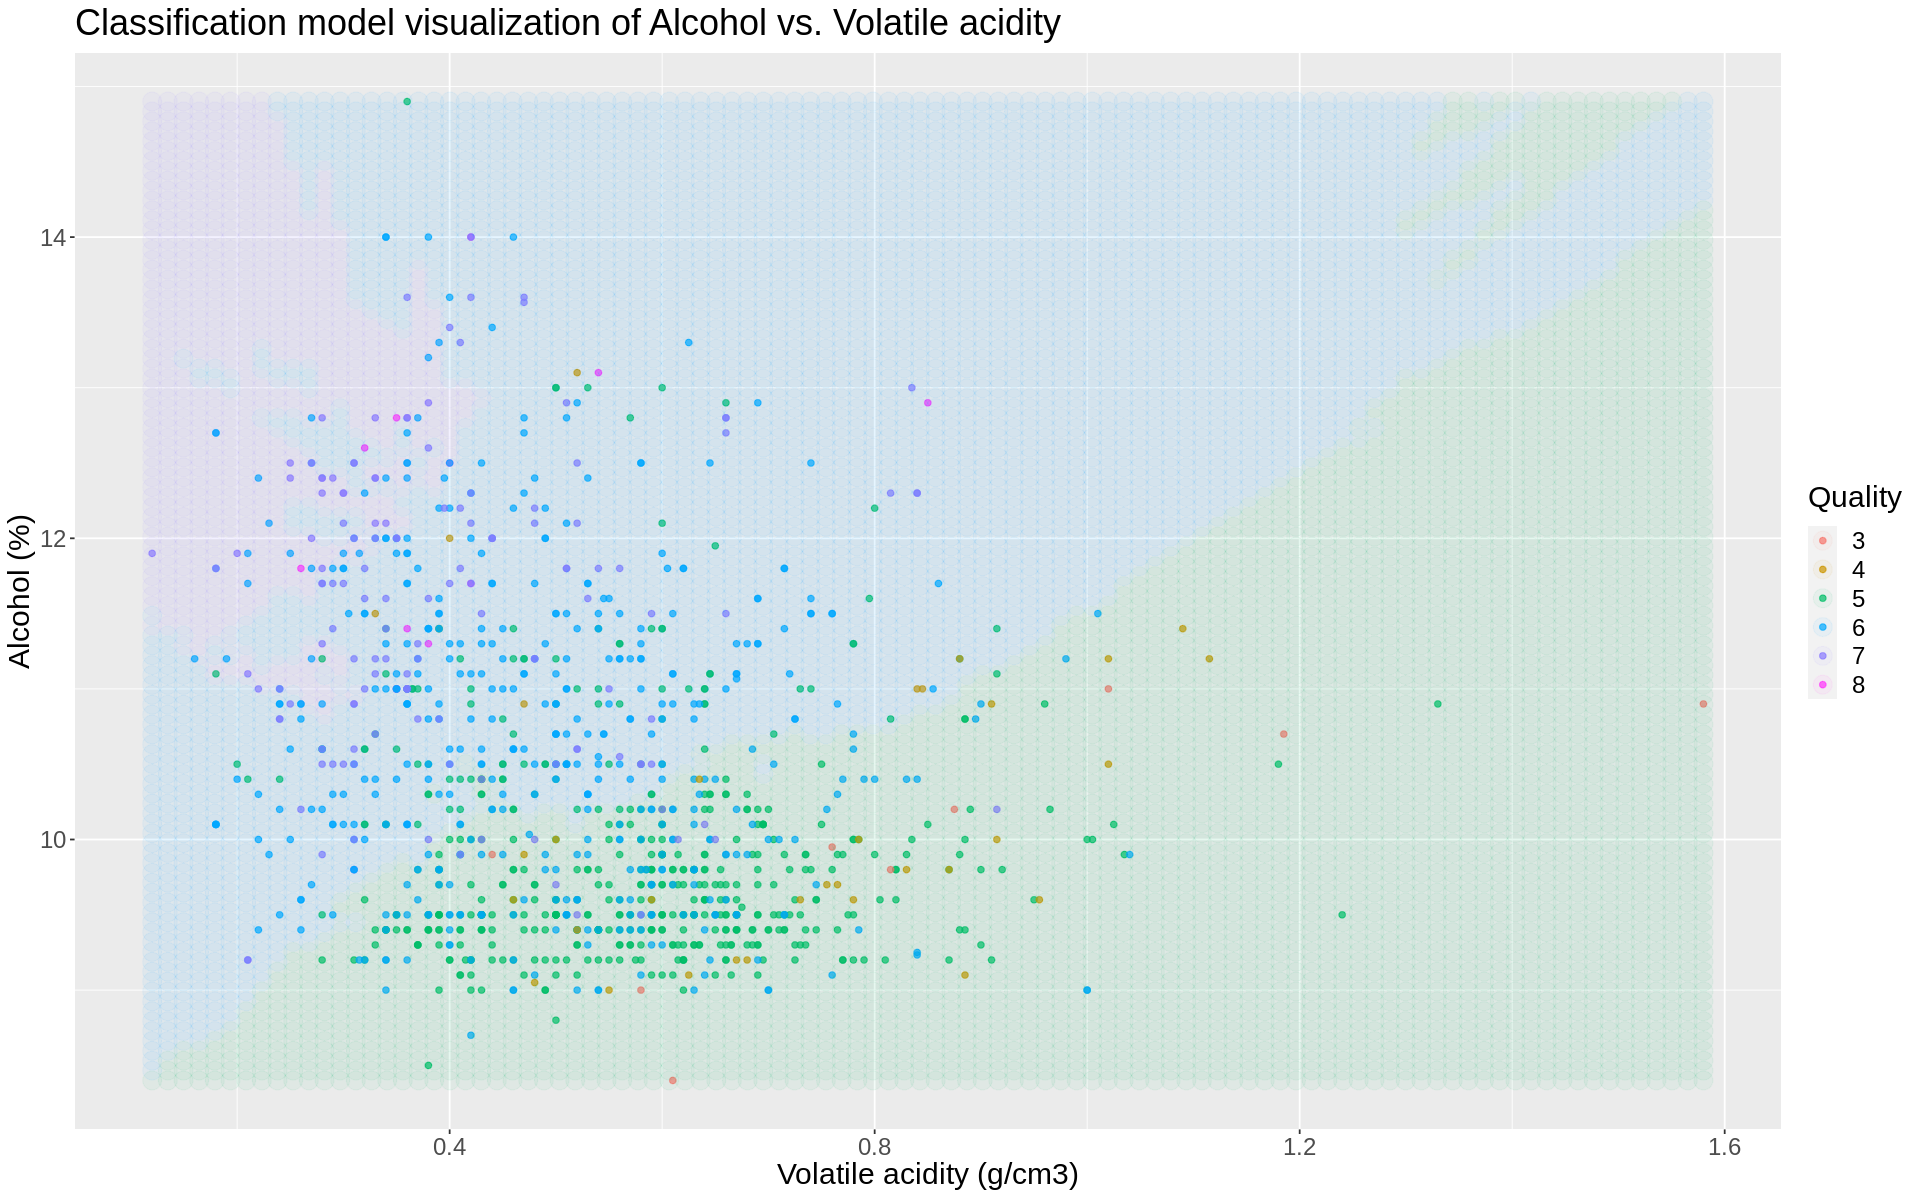

In [14]:
options(repr.plot.width = 16, repr.plot.height = 10)

# create visualization with background color
classification_plot <- ggplot() +
    geom_point(red_training_data, mapping = aes(x = volatile_acidity, y = alcohol, color = quality), alpha = 0.7) +
    geom_point(pred_table, mapping = aes(x = volatile_acidity, y = alcohol, color = quality), alpha = 0.05, size = 5) +
    ggtitle("Classification model visualization of Alcohol vs. Volatile acidity") +
    labs(x = "Volatile acidity (g/cm3)", y = "Alcohol (%)", color = "Quality") + 
    theme(text = element_text(size = 18)) +
    scale_color_manual(values = COLOR_PALETTE)
classification_plot

# \<make sense to do regression?\>
`quality` is numeric, but class (categorical?) variable
may show interesting regression line/curve

## Discussion - come back to this

adsasasd

### References: 
1. https://www.sciencedirect.com/science/article/abs/pii/S0167923609001377

2. insert link

3. https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv